In [1]:
import numpy as np
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
plt.style.use('seaborn-whitegrid')

In [69]:
def timeFromReferenceFactory(daycounter, ref):
    def impl(dat):
        return daycounter.yearFraction(ref, dat)
    return np.vectorize(impl)

def makeSwap(start, maturity, notional, fixedRate, index, tipo = ql.VanillaSwap.Payer):
    """
    Returns the Quantlib swap object
    """
    fixedLegTenor = ql.Period("1y")
    fixedLegBDC = ql.ModifiedFollowing
    floatLegTenor = index.tenor()
    fixedLegDC = index.dayCounter() #ql.Thirty360(ql.Thirty360.BondBasis)
    spread = 0.0
    fixedSchedule = ql.Schedule(start, maturity, fixedLegTenor, index.fixingCalendar(), fixedLegBDC, fixedLegBDC, 
                                   ql.DateGeneration.Backward, False)
    floatSchedule = ql.Schedule(start, maturity, floatLegTenor, index.fixingCalendar(), index.businessDayConvention(),
                                    index.businessDayConvention(), ql.DateGeneration.Backward,False)
    swap = ql.VanillaSwap(tipo, notional,fixedSchedule,fixedRate,fixedLegDC,floatSchedule,index,spread,index.dayCounter())
    return swap

def getfixed(swap, data):
    ###### fixed leg #####
    date_temp = calendar.advance(data, -callability) 
    time_temp = ql.Actual365Fixed().yearFraction(today,date_temp)
    t = time_temp
    fixed_leg = swap.leg(0)
    n = len(fixed_leg)
    fixed_times=[]
    fixed_amounts=[]
    if n == len(date_grid):
        for i in range(n):
            refDate = calendar.advance(date_grid[i], callability) 
            cf = fixed_leg[i]
            cf_time = daycounter.yearFraction(refDate, cf.date() )
            t_i = timeFromReference(cf.date())
            if t_i > t:
                fixed_times.append(t_i)
                fixed_amounts.append(cf.amount())
        fixed_times = np.array(fixed_times)
        fixed_amounts = np.array(fixed_amounts)
    else: 
        for i in range(n):
            cf = fixed_leg[i]
            t_i = timeFromReference(cf.date())
            if t_i > t:
                fixed_times.append(t_i)
                fixed_amounts.append(cf.amount())
        fixed_times = np.array(fixed_times)
        fixed_amounts = np.array(fixed_amounts)
    return fixed_times, fixed_amounts

def getfloating(swap, data):
    float_leg = swap.leg(1)
    t = ql.Actual365Fixed().yearFraction(today,data)
    n = len(float_leg)
    float_times = []
    float_dcf = []
    accrual_start_time = []
    accrual_end_time = []
    nominals = []
    for i in range(n):
        cf = ql.as_floating_rate_coupon(float_leg[i])
        value_date = cf.referencePeriodStart()
        t_fix_i = timeFromReference(value_date)
        t_i = timeFromReference(cf.date()) 
        if t_fix_i >= t:
            iborIndex = cf.index()
            index_mat = cf.referencePeriodEnd()
            float_dcf.append(cf.accrualPeriod())
            accrual_start_time.append(t_fix_i)
            accrual_end_time.append(timeFromReference(index_mat))
            float_times.append(t_i)
            nominals.append(cf.nominal())
    return np.array(float_times), np.array(float_dcf), np.array(accrual_start_time), np.array(accrual_end_time), np.array(nominals)

def swapPathNPV(swap, data):
    fixed_times, fixed_amounts = getfixed(swap, data)
    float_times, float_dcf, accrual_start_time, accrual_end_time, nominals = getfloating(swap, data)
    t = ql.Actual365Fixed().yearFraction(today,data)
    df_times = np.concatenate([fixed_times, accrual_start_time, accrual_end_time, float_times])
    df_times = np.unique(df_times)
    # Store indices of fix leg payment times in the df_times array
    fix_idx = np.in1d(df_times, fixed_times, True)
    fix_idx = fix_idx.nonzero()
    # Indices of the floating leg payment times in the df_times array
    float_idx = np.in1d(df_times, float_times, True)
    float_idx = float_idx.nonzero()
    # Indices of the accrual start and end time in the df_times array
    accrual_start_idx = np.in1d(df_times, accrual_start_time, True)
    accrual_start_idx = accrual_start_idx.nonzero()
    accrual_end_idx = np.in1d(df_times, accrual_end_time, True)
    accrual_end_idx = accrual_end_idx.nonzero()
    # Calculate NPV
    def calc(x_t):
        discount = np.vectorize(lambda T: model.zerobond(T, t, x_t))
        dfs = discount(df_times)
        # Calculate fixed leg npv
        fix_leg_npv = np.sum(fixed_amounts * dfs[fix_idx])
        # Estimate the index fixings
        index_fixings = (dfs[accrual_start_idx] / dfs[accrual_end_idx] - 1) 
        index_fixings /= float_dcf
        # Calculate the floating leg npv
        float_leg_npv = np.sum(nominals * index_fixings * float_dcf * dfs[float_idx])
        npv = float_leg_npv - fix_leg_npv
        return npv ,float_leg_npv, fix_leg_npv
    return calc

def short_rate_path(time_grid):
    m = len(time_grid)
    r_t = np.zeros(m)
    r_std = np.zeros(m)
    numeraire = np.zeros(m)
    for i in range(1, m):
        numeraire[0] = model.numeraire(0,0)
        t0 = time_grid[i-1]
        t1 = time_grid[i]
        e = process.expectation(t0, r_t[i-1], dt[i-1])
        std = process.stdDeviation(t0, r_t[i-1], dt[i-1])
        r_t[i] = np.random.normal(loc= e, scale= std)
        e_0_0 = process.expectation(0,0,t1)
        std_0_0 = process.stdDeviation(0,0,t1)
        r_std[i] = (r_t[i] - e_0_0) / std_0_0
        numeraire[i] = model.numeraire(t1, r_std[i])
    return r_t, r_std, numeraire

def swapSimulation(nPath):
    m = len(time_grid)
    r_t = np.zeros((nPath, m))
    r_std = np.zeros((nPath, m))
    numeraires = np.zeros((nPath, m))
    swapNPV = np.zeros((nPath, m))
    flt = np.zeros((nPath, m))
    fix = np.zeros((nPath, m))
    for i in range(nPath):
        r_t[i], r_std[i], numeraires[i]= short_rate_path(time_grid)
    for i in range(len(date_grid)):
        swapNPV[:,i],flt[:,i],fix[:,i] = np.vectorize(swapPathNPV(swap, date_grid[i]))(r_std[:,i])
    return swapNPV, flt, fix, numeraires, r_std, r_t

def LSM_american(nPath):
    swapNPV, flt, fix, numeraires, y, r = swapSimulation(nPath)
    payoff = swapNPV[:,-1]/numeraires[:,-1]
    payoff[payoff < 0] = 0
    V = np.zeros_like(y)
    V[:,-1] = payoff
    m = len(time_grid) -1
    ols_res = []
    disc_payoff = np.zeros_like(V)
    contin_payoff = np.zeros_like(V)
    disc_payoff[:,-1] = payoff
    for i in range(m-1, 0, -1):
        exercise_values = swapNPV[:,i] / numeraires[:,i]
        exercise_values[exercise_values < 0] = 0
        disc_payoff[:,i] = exercise_values
        states = y[:, i]
        Y = np.column_stack((states, states**2, states**3, states**4))
        Y = sm.add_constant(Y)
        ols = sm.OLS(V[:,i+1], Y)   
        ols_result = ols.fit()
        ols_res.append(ols_result)
        cont_value_hat = np.sum(ols_result.params * Y, axis=1)
        contin_payoff[:,i] = cont_value_hat
        npv_amc = np.maximum(cont_value_hat, exercise_values)
        V[:,i] = np.maximum(cont_value_hat, exercise_values)
    npv_amc =  np.sum(V[:,1]*numeraires[0,0]) / nPath 
    stDev_simulation = np.sqrt((np.sum((V[:,1]*numeraires[0,0] - npv_amc)**2))/nPath)
    stDev_percentage = stDev_simulation / npv_amc
    return npv_amc, stDev_percentage, swapNPV, disc_payoff, contin_payoff



In [93]:
today = ql.Date.from_date(datetime.datetime.now())
ql.Settings.instance().setEvaluationDate(today)
rate = ql.SimpleQuote(0.03)
rate_handle = ql.QuoteHandle(rate)
daycount = ql.Actual365Fixed()
yieldTermStructure = ql.FlatForward(today, rate_handle, daycount)
yieldTermStructure.enableExtrapolation()
handleYieldTermStructure = ql.RelinkableYieldTermStructureHandle(yieldTermStructure)
t0_curve = ql.YieldTermStructureHandle(yieldTermStructure)
index = ql.Euribor6M(handleYieldTermStructure)
calendar = ql.TARGET()
daycounter = yieldTermStructure.dayCounter()
timeFromReference = timeFromReferenceFactory(daycounter, today)

In [94]:
volas = [ql.QuoteHandle(ql.SimpleQuote(0.0075)),
         ql.QuoteHandle(ql.SimpleQuote(0.0075))]
meanRev = [ql.QuoteHandle(ql.SimpleQuote(0.03))]
model = ql.Gsr(t0_curve, [today+100], volas, meanRev, 31.)
process = model.stateProcess()

In [95]:
notional = 1e6
fixedRate = 0.0300373485568933
settlementDate = calendar.advance(today, ql.Period("3d")) 
maturity = settlementDate + ql.Period("3Y")

In [96]:
swap = makeSwap(settlementDate, maturity, notional, fixedRate, index) 
callability = ql.Period("-10d")
swap_fixed_schedule = list(swap.fixedSchedule())
#calldates = [calendar.advance(d, callability) for d in swap_fixed_schedule[1:-1]]
calldates = [calendar.advance(settlementDate, ql.Period("1y")),
             calendar.advance(settlementDate, ql.Period("2y"))]
date_grid = [today] + calldates 
date_grid = np.unique(np.sort(date_grid))
time_grid = np.vectorize(lambda x: ql.Actual365Fixed().yearFraction(today, x))(date_grid)
dt = time_grid[1:] - time_grid[:-1]

In [97]:
np.random.seed(100000)
npv_amc, st_dev, swapNPV, disc_payoff, contin_payoff = LSM_american(100000)
print("NPV american option: %.2f" % npv_amc)
print("Standard deviation:  %.2f%%" % (st_dev))

NPV american option: 6223.87
Standard deviation:  1.47%


In [121]:
swapNPV[:10,0]

array([5.67524694e-10, 5.67524694e-10, 5.67524694e-10, 5.67524694e-10,
       5.67524694e-10, 5.67524694e-10, 5.67524694e-10, 5.67524694e-10,
       5.67524694e-10, 5.67524694e-10])

In [141]:
frame = pd.DataFrame((np.zeros(10),swapNPV[:10,1], swapNPV[:10,2], disc_payoff[:10,1], 
                     contin_payoff[:10,1])).T
frame.columns = ["t0", "t1", "t2", "Exercise Value", "Continuation Value"]

In [143]:
disc_payoff[:10,1]

array([    0.        , 58880.6233219 ,     0.        ,     0.        ,
           0.        ,  3641.51120408,     0.        ,     0.        ,
       18750.25589081,     0.        ])

In [142]:
frame

,t0,t1,t2,Exercise Value,Continuation Value
0,0.0,-970.321427,-15038.101652,0.000000,6562.163111
1,0.0,19373.413205,8675.029906,58880.623322,29017.683475
2,0.0,-7302.702773,-9528.547804,0.000000,3284.449339
3,0.0,-1135.636163,-4656.928396,0.000000,6457.178839
4,0.0,-17279.564568,-32737.423048,0.000000,737.263461
5,0.0,1444.983071,4850.812321,3641.511204,8223.635718
6,0.0,-13304.166917,-8993.909236,0.000000,1426.157162
7,0.0,-9834.305065,6833.354905,0.000000,2367.114878
8,0.0,7021.719152,-1631.418760,18750.255891,13025.992126
9,0.0,-12378.617353,7713.335624,0.000000,1643.763869


In [144]:
import xlwings as xw

In [146]:
wb = xw.Book(r'C:/Users/carap/OneDrive/Desktop/pres/dati.xlsx')
sht = wb.sheets[0]

In [148]:
sht.range("A1").value = frame

In [64]:
modelhw = ql.HullWhite(t0_curve, 0.03, 0.0075)
enginehw = ql.FdHullWhiteSwaptionEngine(modelhw)#ql.TreeSwaptionEngine(modelhw, 50)
exercise = ql.BermudanExercise(calldates)
swaption = ql.Swaption(swap, exercise)
swaption.setPricingEngine(enginehw)
print("LSM simulation npv: %.4f" % npv_amc)
print("Quantlib NPV a t0: %.4f" % swaption.NPV())
print("Errore : %.8f%%" % ((npv_amc - swaption.NPV())/(notional*100)))

LSM simulation npv: 6257.7446
Quantlib NPV a t0: 6265.4879
Errore : -0.00000008%


In [90]:
engine = ql.DiscountingSwapEngine(handleYieldTermStructure)
swap.setPricingEngine(engine)
npv,_,_ = swapPathNPV(swap, date_grid[0])(0)
print("Swap NPV a t0: %.4f" % npv)
print("Quantlib NPV a t0: %.4f" % swap.NPV())
print("Errore : %.8f" % (npv - swap.NPV()))

Swap NPV a t0: 106.9743
Quantlib NPV a t0: 106.9743
Errore : 0.00000000


In [91]:
swap.fairRate()

0.0300373485568933

#### PLOT

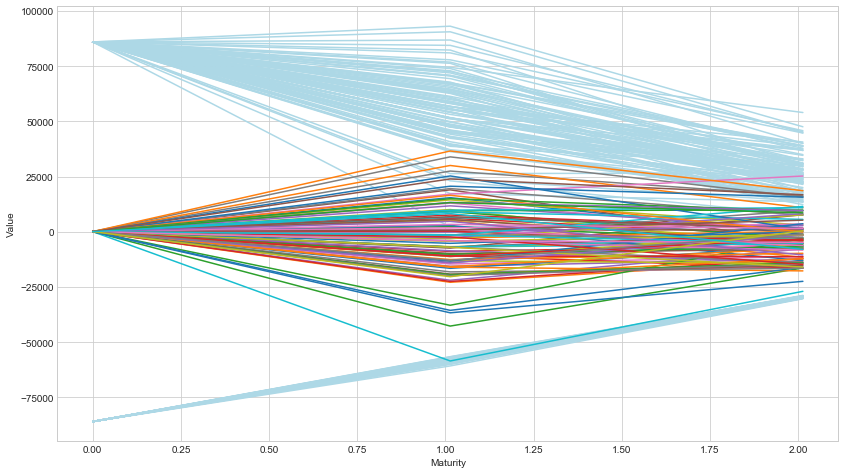

In [32]:
swapNPV, flt, fix,_,_,_  = swapSimulation(100)
fig = plt.figure(figsize=(14,8))
plt.plot(time_grid, -fix.T, color = "lightblue")
plt.plot(time_grid, flt.T, color = "lightblue")
plt.plot(time_grid, swapNPV.T)
plt.xlabel("Maturity")
plt.ylabel("Value")
plt.show()

In [33]:
time_grid

array([0.        , 1.01369863, 2.01369863])

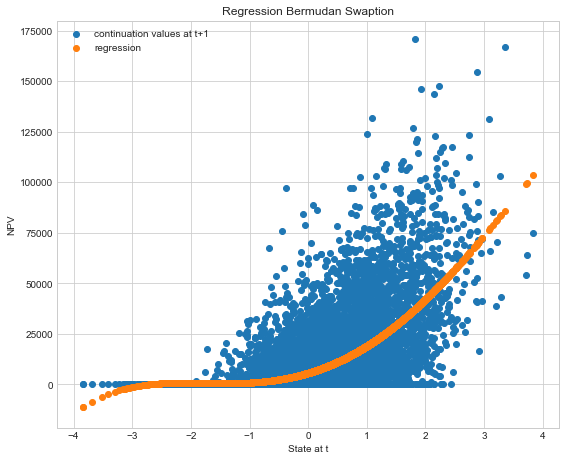

In [37]:
swapNPV, flt, fix, numeraires, y, r = swapSimulation(10000)
payoff = swapNPV[:,-1]/numeraires[:,-1]
payoff[payoff < 0] = 0
V = np.zeros_like(y)
V[:,-1] = payoff
m = len(time_grid) -1
ols_res = []
payoff = swapNPV[:,-1]/numeraires[:,-1]
payoff[payoff < 0] = 0
states = y[:, -2]
Y = np.column_stack((states, states**2, states**3, states**4))
Y = sm.add_constant(Y)
ols = sm.OLS(payoff, Y)   
ols_result = ols.fit()
cont_value_hat = np.sum(ols_result.params * Y, axis=1)

plt.figure(figsize=(9,7.5))
plt.scatter(states, payoff)
plt.scatter(states, cont_value_hat)
plt.legend(["continuation values at t+1", "regression"])
plt.title("Regression Bermudan Swaption")
plt.xlabel("State at t")
plt.ylabel("NPV")
plt.show()

### CAP/FLOOR formula Hull-White

In [15]:
import scipy.stats

In [16]:
settlementDate = calendar.advance(today, ql.Period("3d")) 
maturity = settlementDate + ql.Period("1Y")
notional = 1e6
fixedRate = 0.03
index = ql.Euribor6M(handleYieldTermStructure)

swap = makeSwap(settlementDate, maturity, notional, fixedRate, index) 

In [17]:
capFloorSchedule = ql.Schedule(settlementDate, maturity, ql.Period("1y"),
                       calendar, ql.ModifiedFollowing, ql.ModifiedFollowing, 
                       ql.DateGeneration.Forward, False)
iborLeg = ql.IborLeg([notional], capFloorSchedule, index)

In [18]:
strike = 0.03
cap = ql.Cap(iborLeg, [strike])
floor = ql.Floor(iborLeg, [strike])
vol = ql.QuoteHandle(ql.SimpleQuote(0.75))
engine = ql.BlackCapFloorEngine(handleYieldTermStructure, vol)

cap.setPricingEngine(engine)

In [19]:
cap.optionletsPrice()

(482.94384933373897,)

In [20]:
cap.setPricingEngine(engine)
floor.setPricingEngine(engine)
print ("CAP NPV: %.2f"%cap.NPV())
print( "FLOOR NPV: %.2f"% floor.NPV())

CAP NPV: 482.94
FLOOR NPV: 444.88


In [21]:
a = 0.03
sigma = 0.075
t = 0
T = 0
S = 1

In [22]:
### t < T < S
def N(x):
    return scipy.stats.norm.cdf(x)

def sigma_p_i(a, sigma, T, S):
    tau = S - T
    B = (1/a)*(1-np.exp(-a*tau))
    sqroot = (1- np.exp(-2*a*tau))/(2*a)
    return sigma*np.sqrt(sqroot)*B

def h_i(a, sigma, T, S, X,P_t_S, P_t_T):
    tau = S - T
    inlog = (P_t_S*(1 + X*tau))/P_t_T   # tau???
    return (1/sigma_p_i(a,sigma,T, S))*np.log(inlog) + sigma_p_i(a,sigma,T, S)/2

In [23]:
P_t_T = 1.0
P_t_S = 1.0
X = 0.03

In [24]:
caplet = P_t_T*N(-h_i(a,sigma,T,S,X,P_t_S,P_t_T)+sigma_p_i(a,sigma,T,S))
caplet += -(1+X*(S - T))*P_t_S*N(-h_i(a,sigma,T,S,X,P_t_S,P_t_T))
pv = notional*caplet

In [25]:
pv

16864.260833035438